# K-Means Clustering

### Authors

| Name | Roll Number |
|-|-|
| Gautam Singh | CS21BTECH11018 |
| Jaswanth Beere | BM21BTECH11007 |

This `.ipynb` notebook performs K-Means Clustering and analyses the impact of
preprocessing data using Principal Component Analysis (PCA) on the SVHN dataset.

## Obtaining the Data

The SVHN dataset is obtained using the `curl` command on the appropriate file
URL.

In [1]:
%%bash

if [ ! -f train_32x32.mat ]; then
    curl -O http://ufldl.stanford.edu/housenumbers/train_32x32.mat
fi

In [2]:
%%bash

if [ ! -f test_32x32.mat ]
then
    curl -O http://ufldl.stanford.edu/housenumbers/test_32x32.mat
fi

## Package Imports

For this exercise, the following packages must be installed and imported.

In [3]:
%pip install numpy scikit-learn matplotlib scipy

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy import io
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

## Loading the Data

We begin by loading the data into `numpy` arrays for processing.

In [5]:
# Load training and test data

train_data = io.loadmat('train_32x32.mat')
test_data = io.loadmat('test_32x32.mat')

# Separate training data inputs (images) and outputs (classes)

train_X = train_data['X']
train_Y = train_data['y']
test_X = test_data['X']
test_Y = test_data['y']

NUM_TRAIN_SAMPLES = train_X.shape[-1]
NUM_TEST_SAMPLES = test_X.shape[-1]

Next, we reshape the dimensions of `train_X` such that the first index
represents sample number. Further, we scale all features to zero mean and unit
variance.

In [6]:
# Reshape train_X such that train_X[i] is the ith image in the dataset
# Further, flatten image arrays for PCA.

train_X_reshaped = train_X.reshape(32*32*3, NUM_TRAIN_SAMPLES).T
test_X_reshaped = test_X.reshape(32*32*3, NUM_TEST_SAMPLES).T
train_Y_reshaped = train_Y.ravel()
test_Y_reshaped = test_Y.ravel()

## Sampling the Data

To perform PCA on the given dataset, we sample 2500 data points of each digit
from 0 to 9, giving us 25000 training examples to perform PCA on. Note that 0 is
represented as 10 in the dataset.

In [7]:
# Sample 2500 training examples for each digit
NUM_SAMPLES_PER_CLASS = 2500

# Use a numpy random number generator
rng = np.random.default_rng()

# Array of randomly chosen indices
ind_arr = np.array([])

for i in range(1,11,1):
    # Find the indices in the training set corresponding to digit
    idx = np.where(train_Y == i)[0]
    # Generate samples randomly
    rand_samples = rng.choice(idx, NUM_SAMPLES_PER_CLASS, False)
    # Append to index array
    ind_arr = np.append(ind_arr, rand_samples)

ind_arr = np.asarray(ind_arr, int)
# Finally, generate random samples and their labels
train_X_gen = train_X_reshaped[ind_arr]
train_Y_gen = train_Y[ind_arr]

We can now perform PCA on the sampled training dataset, taking different numbers of components.

In [8]:
# Initialize a scaler object for both training and testing
train_scaler = StandardScaler()
train_scaler.fit(train_X_gen)
train_X_gen_scaled = train_scaler.transform(train_X_gen)

test_scaler = StandardScaler()
test_scaler.fit(test_X_reshaped)
test_X_reshaped_scaled = test_scaler.transform(test_X_reshaped)

# Initialize the PCA class instances
pca_10 = PCA(n_components=10)
pca_27 = PCA(n_components=27)

# Perform PCA on the scaled data
pca_10.fit(train_X_gen)
pca_27.fit(train_X_gen)

train_X_pca_10 = pca_10.transform(train_X_gen_scaled)
train_X_pca_27 = pca_27.transform(train_X_gen_scaled)

test_X_pca_10 = pca_10.transform(test_X_reshaped_scaled)
test_X_pca_27 = pca_27.transform(test_X_reshaped_scaled)

## K-Means Clustering and PCA

In this section, we will perform K-Means clustering with the preprocessed sampled training dataset. Here, `k = 10`.

In [9]:
# Set number of clusters
K = 10

### Raw Data

Classes that appear in each k-means cluster
0 : [ 1  2  3  4  5  6  7  8  9 10]
1 : [ 1  2  3  4  5  6  7  8  9 10]
2 : [ 1  2  3  4  5  6  7  8  9 10]
3 : [ 1  2  3  4  5  6  7  8  9 10]
4 : [ 1  2  3  4  5  6  7  8  9 10]
5 : [ 1  2  3  4  5  6  7  8  9 10]
6 : [ 1  2  3  4  5  6  7  8  9 10]
7 : [ 1  2  3  4  5  6  7  8  9 10]
8 : [ 1  2  3  4  5  6  7  8  9 10]
9 : [ 1  2  3  4  5  6  7  8  9 10]


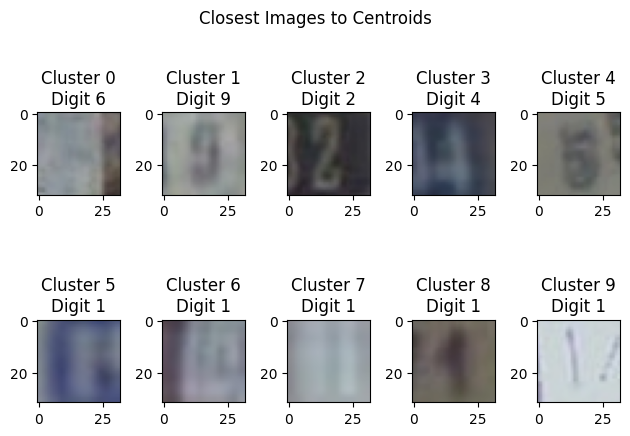

In [10]:
# Perform K-Means on the preprocessed training data
kmeans_10 = KMeans(n_clusters=K, n_init=K)
kmeans_10 = kmeans_10.fit(train_X_gen)

# Iterate over K labels and output which actual classes are grouped together
print("Classes that appear in each k-means cluster")
for i in range(K):
    # Get indices having this K-means label
    idx = np.where(kmeans_10.labels_ == i)[0]
    # Find unique values
    clust_uniq = np.unique(train_Y_gen[idx])
    # Print the cluster and associated digit classes
    print(i, ":", clust_uniq)

# Iterate over K labels and output closest centroid
fig = plt.figure()
for i in range(K):
    # Get centroid of this label
    centroid_i = kmeans_10.cluster_centers_[i]
    # Find the closest point to the label
    closest_pt_idx = (((train_X_gen)-centroid_i[None, :])**2).sum(1).argmin()
    closest_pt_i = train_X_gen[closest_pt_idx]
    # Display closest point along with cluster number and label
    sub = fig.add_subplot(2, 5, i+1)
    sub.imshow(closest_pt_i.reshape(32,32,3))
    sub.set_title('Cluster ' + str(i) + '\nDigit ' + str(train_Y_gen[closest_pt_idx][0]%10))

fig.suptitle('Closest Images to Centroids')
fig.tight_layout()

#### Evaluation Metrics

##### Purity

In [11]:
# Compute purity as fraction of most frequent label in cluster
pur_arr = np.array([])
print("Purity of each cluster")
for i in range(K):
    # Compute digits in the cluster
    digits = train_Y_gen[np.where(kmeans_10.labels_ == i)[0]].ravel()
    # Compute maximum frequency in cluster
    max_freq_i = np.bincount(digits).max()
    # Compute purity of the cluster
    purity = max_freq_i/len(digits)
    pur_arr = np.append(pur_arr, purity)
    print(i, ":", purity)
print("Average purity:", np.mean(pur_arr))

Purity of each cluster
0 : 0.14073494917904614
1 : 0.11423220973782772
2 : 0.11372411372411373
3 : 0.11971603743142949
4 : 0.1044071353620147
5 : 0.11901565995525727
6 : 0.19718309859154928
7 : 0.11047227926078029
8 : 0.11328125
9 : 0.11252115059221658
Average purity: 0.12452878838342352


### Using 27 Eigenvectors

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Classes that appear in each k-means cluster
0 : [ 1  2  3  4  5  6  7  8  9 10]
1 : [ 1  2  3  4  5  6  7  8  9 10]
2 : [ 1  2  3  4  5  6  7  8  9 10]
3 : [ 1  2  3  4  5  6  7  8  9 10]
4 : [ 1  2  3  4  5  6  7  8  9 10]
5 : [ 1  2  3  4  5  6  7  8  9 10]
6 : [ 1  2  3  4  5  6  7  8  9 10]
7 : [ 1  2  3  4  5  6  7  8  9 10]
8 : [ 1  2  3  4  5  6  7  8  9 10]
9 : [ 1  2  3  4  5  6  7  8  9 10]
[-6.40311079e+03 -3.15222212e+02  3.13925989e+02 -1.34292731e+02
 -2.14186216e+02  7.02541345e+00 -9.22420901e+00  1.69526331e+01
 -7.73619211e+01  3.48818088e+01 -2.00106260e+01  2.78798014e+01
 -1.12315772e+00  2.22979516e+01 -8.47940304e-01  2.44615343e+01
 -6.95272197e+00 -7.63223871e+00 -1.24603707e+01 -2.75647485e+01
  4.18419842e+00  2.45832216e+01  1.21558446e+01 -4.81169902e+01
 -9.86532690e+00 -2.00444843e+01  3.10862407e+00]
[-6.38111870e+03 -3.31054298e+02  2.97898584e+02 -1.50334916e+02
 -2.10517397e+02  8.10437917e+00 -1.19812270e+01  1.73902508e+01
 -7.39643867e+01  3.280904

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-6.42554680e+03 -3.31724691e+02  3.27786409e+02 -1.34090442e+02
 -2.12001298e+02  1.28696604e+01 -1.48773327e+01  1.81186322e+01
 -8.19869703e+01  3.60873438e+01 -1.75181419e+01  2.80492856e+01
 -2.41402651e-01  2.68055562e+01  2.54917702e+00  2.75425657e+01
 -6.50433230e+00 -1.11892910e+01 -1.34663075e+01 -2.72811222e+01
  3.93862286e+00  2.20927184e+01  1.50104673e+01 -4.54255814e+01
 -9.51161496e+00 -1.80440259e+01 -8.47915604e-01]
[-6.36991315e+03 -3.30250095e+02  3.30751845e+02 -1.34412353e+02
 -2.11516091e+02  4.78114566e+00 -1.12450792e+01  1.55543758e+01
 -8.10282288e+01  3.21833471e+01 -1.42747413e+01  2.78870314e+01
  5.01479950e-01  2.28899960e+01  1.16375420e+00  2.77525344e+01
 -4.89712914e+00 -9.58753143e+00 -1.52630430e+01 -3.08790061e+01
  4.14729436e+00  2.52843619e+01  1.52700143e+01 -4.52233049e+01
 -8.99692043e+00 -1.84955245e+01 -9.95775127e-02]
[-6.29642010e+03 -3.18231664e+02  3.13071203e+02 -1.37422701e+02
 -2.07711123e+02  7.62149011e+00 -1.26771983e+01  1.561

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


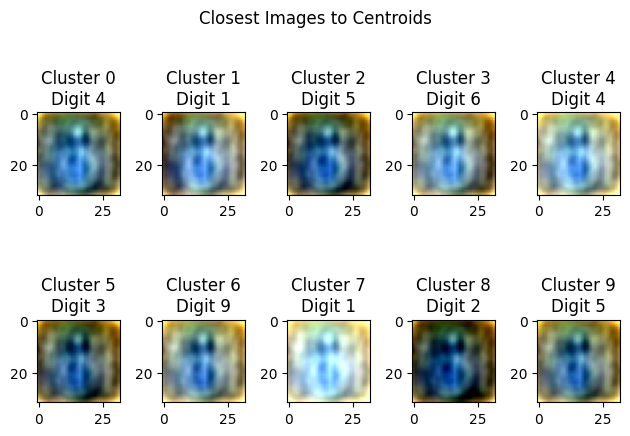

In [12]:
# Perform K-Means on the preprocessed training data
kmeans_10 = KMeans(n_clusters=K, n_init=K)
kmeans_10 = kmeans_10.fit(train_X_pca_27)

# Iterate over K labels and output which actual classes are grouped together
print("Classes that appear in each k-means cluster")
for i in range(K):
    # Get indices having this K-means label
    idx = np.where(kmeans_10.labels_ == i)[0]
    # Find unique values
    clust_uniq = np.unique(train_Y_gen[idx])
    # Print the cluster and associated digit classes
    print(i, ":", clust_uniq)

# Iterate over K labels and output closest centroid
fig = plt.figure()
for i in range(K):
    # Get centroid of this label
    centroid_i = kmeans_10.cluster_centers_[i]
    # Find the closest point to the label
    closest_pt_idx = ((train_X_pca_27-centroid_i[None, :])**2).sum(1).argmin()
    closest_pt_i = train_X_pca_27[closest_pt_idx]
    print(closest_pt_i)
    # Display closest point along with cluster number and label
    sub = fig.add_subplot(2, 5, i+1)
    sub.imshow(np.asarray(train_scaler.inverse_transform(pca_27.inverse_transform(np.array([closest_pt_i]))).reshape(32,32,3), int))
    sub.set_title('Cluster ' + str(i) + '\nDigit ' + str(train_Y_gen[closest_pt_idx][0]%10))

fig.suptitle('Closest Images to Centroids')
fig.tight_layout()

#### Evaluation Metrics

##### Purity

In [13]:
# Compute purity as fraction of most frequent label in cluster
pur_arr = np.array([])
print("Purity of each cluster")
for i in range(K):
    # Compute digits in the cluster
    digits = train_Y_gen[np.where(kmeans_10.labels_ == i)[0]].ravel()
    # Compute maximum frequency in cluster
    max_freq_i = np.bincount(digits).max()
    # Compute purity of the cluster
    purity = max_freq_i/len(digits)
    pur_arr = np.append(pur_arr, purity)
    print(i, ":", purity)
print("Average purity:", np.mean(pur_arr))

Purity of each cluster
0 : 0.12356067316209035
1 : 0.19324577861163228
2 : 0.12138728323699421
3 : 0.14009661835748793
4 : 0.10696920583468396
5 : 0.11756645656344204
6 : 0.11620043037196434
7 : 0.1111111111111111
8 : 0.11388400702987697
9 : 0.10411311053984576
Average purity: 0.12481346748191291
